# Importing Libraries :

In [1]:
import gc
import os
import random
import sys

from tqdm import tqdm_notebook as tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from IPython.core.display import display, HTML

from math import sqrt
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')



# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# --- models ---
#from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
#import catboost as cb

# Memory Reduction :

In [2]:
# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified to support timestamp type, categorical type
# Modified to add option to use float16 or not. feather format does not support float16.
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def memory_reduction(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            # skip datetime type or categorical type
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'
          .format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

# Reading Merged test data :

In [3]:
merged_test = pd.read_feather('../input/energy-feature-engineering-2/merged_test.feather')

In [4]:
merged_test.shape

(41697600, 18)

In [5]:
merged_test["hour"] = merged_test["timestamp"].dt.hour

In [6]:
merged_test = merged_test.drop(['index','row_id',"timestamp"],axis=1)

In [7]:
X_test = memory_reduction(merged_test,use_float16=False)

Memory usage of dataframe is 2028.06 MB
Memory usage after optimization is: 1749.70 MB
Decreased by 13.7%


In [8]:
del merged_test

In [9]:
X_test.shape

(41697600, 16)

In [10]:
X_test.columns

Index(['building_id', 'meter', 'weekend', 'site_id', 'primary_use',
       'square_feet', 'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'IsHoliday', 'month_group', 'horizsolar',
       'Sensible_Heat', 'relative_humidity', 'hour'],
      dtype='object')

In [11]:
def pred(X_test, models, batch_size=2000000):
    '''
    This function predicts test data with given batchsize for every iteration
    '''
    iterations = (X_test.shape[0] + batch_size -1) // batch_size
    print('iterations', iterations)

    y_test_pred_total = np.zeros(X_test.shape[0])
    
        
    for k in tqdm(range(iterations)):
        y_pred_test = models.predict(X_test[k*batch_size:(k+1)*batch_size])
        y_test_pred_total[k*batch_size:(k+1)*batch_size] += y_pred_test

    return y_test_pred_total

# Prediction of last seven models :

In [12]:
import pickle
test_pred = []
for i in tqdm(range(8,15)) : 
    print("predicting model :",i)

    filename = "../input/training-15modelsforstacking/lgb_reg"+ str(i) +".sav"
    print("model :",i)
    regressor = pickle.load(open(filename,'rb'))
    
    predict_test = pred(X_test,regressor)
    
    #predict_test =  regressor.predict(X_test)
    test_pred.append(predict_test)
       
                

predicting model : 8
model : 8
iterations 21



predicting model : 9
model : 9
iterations 21



predicting model : 10
model : 10
iterations 21



predicting model : 11
model : 11
iterations 21



predicting model : 12
model : 12
iterations 21



predicting model : 13
model : 13
iterations 21



predicting model : 14
model : 14
iterations 21


In [13]:
import joblib      
joblib.dump(test_pred, 'test_pred_8to15_lgb.pkl')  #storing in pickle file                      

['test_pred_8to15_lgb.pkl']

# Loading Pickle files :

In [14]:
import joblib 
#valid_pred = joblib.load('../input/training-15modelsforstacking/valid_pred_new15__15lgb.pkl') 
#yy_valid =joblib.load('../input/training-15modelsforstacking/yy__valid_new15_lgb.pkl')
test_pred1 =joblib.load('../input/testing-15models-1/test_pred_1to7_lgb.pkl')
test_pred2 =joblib.load('../input/addtest-1/test_pred_8to15_lgb.pkl')

"import joblib \nvalid_pred = joblib.load('../input/training-15modelsforstacking/valid_pred_new15__15lgb.pkl') \nyy_valid =joblib.load('../input/training-15modelsforstacking/yy__valid_new15_lgb.pkl')\ntest_pred1 =joblib.load('../input/testing-15models-1/test_pred_1to7_15lgb.pkl')\ntest_pred2 =joblib.load('../input/addtest/test_pred_8to15_15lgb.pkl')"

In [15]:
test_pred = test_pred1 + test_pred2

In [16]:
del test_pred1,test_pred2

In [17]:
print(len(test_pred))  

In [ ]:
test_pred = np.array(test_pred)
test_pre  = np.transpose(test_pred)
test_pre.shape

In [20]:
#del test_pred

In [24]:
t = test_pre.sum(axis = 1)  #summation of prediction data of all models for average

In [25]:
len(t)

In [26]:
t = t/15# taking average of all models
pred = np.expm1(t)          

In [27]:
#del predict_y,yy_valid,valid_pred

In [28]:
#del test_pre,valid_pre

In [29]:
#len(pred) 

In [30]:
sample_submission = pd.read_feather("../input/ashrae-feather-format-for-fast-loading/sample_submission.feather")
sample_submission = memory_reduction(sample_submission)            

Memory usage of dataframe is 636.26 MB
Memory usage after optimization is: 198.83 MB
Decreased by 68.7%


In [31]:
row_ids = merged_test["row_id"]

In [32]:
sample_submission = pd.DataFrame({"row_id": row_ids, "meter_reading": np.clip(pred, 0, a_max=None)})
sample_submission['meter_reading'] = sample_submission['meter_reading'].astype('float32')
sample_submission['row_id'] = sample_submission['row_id'].astype('int32')

In [34]:
sample_submission.to_csv('15models_stacking_lgbNAN.csv',index=False) 

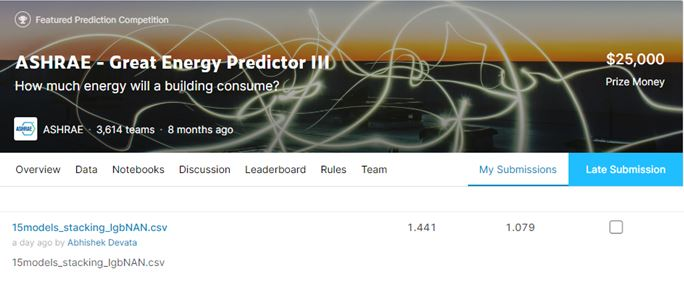

In [1]:
from IPython.display import Image
Image(filename='15models_stacking_lgbNAN.JPG')                  